# Advanced pandas - Going Beyond the Basics

## pandasAI
___

### Table of Contents
1. [Import dependencies](#section1)
2. [Import dataset](#section2)
3. [Instantiate OpenAI LLM and SmartDataframe](#section3)
4. [Running queries](#section4)
5. [Enforcing privacy](#section5)
6. [Common data manipulations](#section6)
7. [Working on multiple DataFrames with SmartDatalake](#section7)
8. [Shortcuts](#section8)

___
<a id='section1'></a>
# (1) Import dependencies

In [1]:
# Install pandasAI (compulsory to run this cell)
# Note that pandasai v1.2.2 is only compatible with pandas 1.5.3
!pip install pandasai==1.2.2

In [2]:
import numpy as np
import pandas as pd
import pandasai
from pandasai.llm import OpenAI
from pandasai import SmartDataframe, SmartDatalake

___
<a id='section2'></a>
# (2) Import dataset
- For this lesson, we will be using a mock dataset of customers of a retail shop.
- Data Source: https://www.kaggle.com/datasets/datascientistanna/customers-dataset (Database Contents License (DbCL) v1.0)

In [3]:
# Import and read CSV file
df = pd.read_csv('https://raw.githubusercontent.com/kennethleungty/Educative-Advanced-Pandas/main/data/csv/Customers_Mini.csv')

# Set CustomerID as index
df = df.set_index('CustomerID')

# View entire DataFrame
df

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
1,Male,19,15000,39,Scientist,1,4
2,Male,21,35000,81,Engineer,3,3
3,Female,20,86000,6,Engineer,1,1
4,Female,23,59000,77,Lawyer,0,2
5,Female,31,38000,40,Artist,2,6
6,Female,22,58000,76,Engineer,0,2
7,Female,35,31000,6,Scientist,1,3


___
<a id='section3'></a>
# (3) Instantiate OpenAI LLM and SmartDataframe
We need to first set up the OpenAI API connection to our desired large language model (LLM), and then instantiate a `pandasAI` SmartDataframe object for which we will pass our DataFrame and query into.

A SmartDataframe is a pandas (or polars) DataFrame that inherits all the properties and methods from the DataFrame object, but also adds conversational capabilities to it.

> **Note**: For this lesson, we will make use of OpenAI GPT3.5 (aka 
gpt-3.5-turbo) LLM. The list of supported Chat models includes "gpt-4", "gpt-4-0314", "gpt-4-32k", "gpt-4-32k-0314","gpt-3.5-turbo", "gpt-3.5-turbo-0301".

> Check out this link to find out how to retrieve your OpenAI API key: https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key

## NOTE: Please enter your OpenAI API key in the following cell before proceeding
#### Your API key is fully private and will only be visible to you. Educative will not be able to have access to it

In [4]:
# Setup OpenAI LLM
OPENAI_API_KEY = 'xxx' # insert your API Key here
llm = OpenAI(api_token=OPENAI_API_KEY) # Default is GPT3.5

In [5]:
# Instantiate SmartDataframe from LLM
sdf = SmartDataframe(df, config={'llm': llm})

It is important to note that a SmartDataframe has all the methods and properties of the original DataFrame. For example, we can also perform basic filtering, as shown below where we filter the data to customers with age above 21:

In [6]:
sdf[sdf['Age'] > 21]

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
4,Female,23,59000,77,Lawyer,0,2
5,Female,31,38000,40,Artist,2,6
6,Female,22,58000,76,Engineer,0,2
7,Female,35,31000,6,Scientist,1,3


For the rest of this lesson, we will focus on how we can run queries on the data using natural language.

___
<a id='section4'></a>
# (4) Running queries
We now put `pandasAI` to the test by passing text queries to obtain the output required, with the use of the SmartDataframe `chat()` method.

Besides text and DataFrame output, `pandasAI` can also be used to generate charts and visualizations.

In [7]:
# Ask generic queries
sdf.chat('Which is the most common profession?')

'The most common profession is Engineer.'

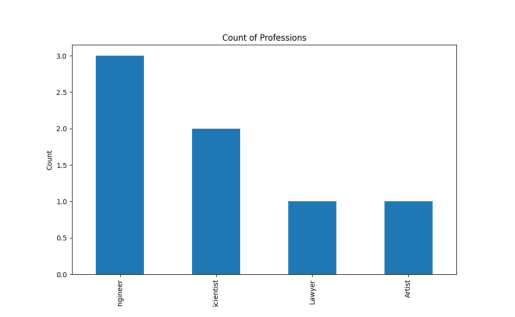

In [8]:
sdf.chat('Give me a histogram of the count of professions')

In [9]:
sdf.chat('What is the gender ratio of males to females')

'The gender ratio of males to females is 0.29:0.71'

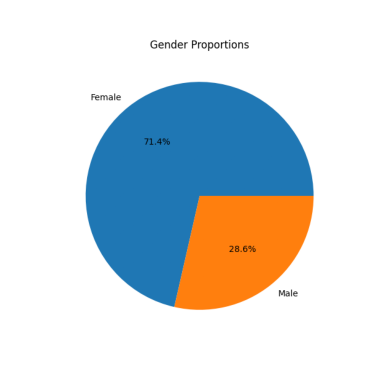

In [10]:
sdf.chat('Give me a pie chart to show the gender proportions')

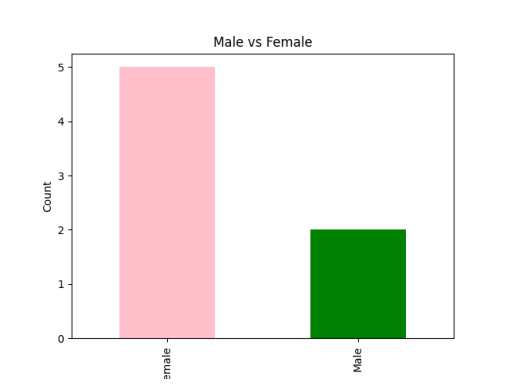

In [11]:
sdf.chat('Give me bar plot of male versus female in pink vs green colors, where female is pink color')

In [12]:
sdf.chat('Give me a DataFrame filtered to only scientist profession')

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
1,Male,19,15000,39,Scientist,1,4
7,Female,35,31000,6,Scientist,1,3


The examples above show how easy it is for us to use language to generate a variety of analysis output we may need.

To view what was the code generated to execute our most recent natural language query, we can utilize the `last_code_executed` attribute, as shown below:

In [13]:
print(sdf.last_code_executed)

def analyze_data(dfs: list[pd.DataFrame]) ->dict:
    """
    Analyze the data
    1. Prepare: Preprocessing and cleaning data if necessary
    2. Process: Manipulating data for analysis (grouping, filtering, aggregating, etc.)
    3. Analyze: Conducting the actual analysis (if the user asks to plot a chart save it to an image in exports/charts/temp_chart.png and do not show the chart.)
    4. Output: return a dictionary of:
    - type (possible values "text", "number", "dataframe", "plot")
    - value (can be a string, a dataframe or the path of the plot, NOT a dictionary)
    Example output: { "type": "text", "value": "The average loan amount is $15,000." }
    """
    filtered_df = dfs[0][dfs[0]['Profession'] == 'Scientist']
    return {'type': 'dataframe', 'value': filtered_df}


___
<a id='section5'></a>
# (5) Enforcing privacy

By default, `pandasAI` introduces privacy measures by not ingesting the entire DataFrame passed into it. Instead, what it does is that it takes the DataFrame head, randomizes the data within (using random generation for sensitive data and shuffling for non-sensitive data), and then passing the first five randomized rows (i.e., DataFrame head) into the LLM.

If wish to further enforce the privacy aspect, we can utilize the `enforce_privacy` configuration in the SmartDataframe object such that we only send the column names to the LLM, without sending any data rows through.

In [14]:
# Enforce privacy by setting enforce_privacy=True in config parameter
sdf = SmartDataframe(df, 
                     config={'llm': llm,
                             'enforce_privacy': True})

In [15]:
sdf.enforce_privacy

True

___
<a id='section6'></a>
# (6) Common data manipulations

Now that we have a general grasp of `pandasAI`, let us see go through several examples involving numerous common data manipulations that we may perform:

In [16]:
# Reinstantiate SmartDataframe to reset it to default privacy settings
sdf = SmartDataframe(df, 
                     config={'llm': llm,
                             'enforce_privacy': False})

## Describing the DataFrame

In [17]:
prompt = 'describe the information of the dataframe'
sdf.chat(prompt)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 2 to 1
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          5 non-null      object
 1   Age             5 non-null      int64 
 2   AnnualIncome    5 non-null      int64 
 3   SpendingScore   5 non-null      int64 
 4   Profession      5 non-null      object
 5   WorkExperience  5 non-null      int64 
 6   FamilySize      5 non-null      int64 
dtypes: int64(5), object(2)
memory usage: 320.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 1 to 7
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          7 non-null      object
 1   Age             7 non-null      int64 
 2   AnnualIncome    7 non-null      int64 
 3   SpendingScore   7 non-null      int64 
 4   Profession      7 non-null      object
 5   WorkExperience  7 non-null      int6

## Data selection and filtering

In [18]:
prompt = 'give me a dataframe of female customers with annual income above 40000'
sdf.chat(prompt)

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
3,Female,20,86000,6,Engineer,1,1
4,Female,23,59000,77,Lawyer,0,2
6,Female,22,58000,76,Engineer,0,2


## Sorting

In [19]:
prompt = 'return the dataframe sorted by annual income in descending order'
sdf.chat(prompt)

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
3,Female,20,86000,6,Engineer,1,1
4,Female,23,59000,77,Lawyer,0,2
6,Female,22,58000,76,Engineer,0,2
5,Female,31,38000,40,Artist,2,6
2,Male,21,35000,81,Engineer,3,3
7,Female,35,31000,6,Scientist,1,3
1,Male,19,15000,39,Scientist,1,4


## Groupby and aggregation

In [20]:
prompt = 'group by gender and give me the average age'
sdf.chat(prompt)

,Gender,Age
0,Female,26.2
1,Male,20.0


## Reshaping

In [21]:
prompt = 'generate pivot table of gender and profession, with the values being average annual income'
sdf.chat(prompt)

Profession,Artist,Engineer,Lawyer,Scientist
Gender,,,,
Female,38000.0,72000.0,59000.0,31000.0
Male,NaN,35000.0,NaN,15000.0


## Arithmetic operations

In [22]:
prompt = 'return me a dataframe where the annual income is divided by 100'
sdf.chat(prompt)

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
1,Male,19,150.0,39,Scientist,1,4
2,Male,21,350.0,81,Engineer,3,3
3,Female,20,860.0,6,Engineer,1,1
4,Female,23,590.0,77,Lawyer,0,2
5,Female,31,380.0,40,Artist,2,6
6,Female,22,580.0,76,Engineer,0,2
7,Female,35,310.0,6,Scientist,1,3


## Data Cleaning

In [23]:
# Introduce 8 random NaN values into our DataFrame (simulate a dataset with NaN values)
n = 8 
df_with_nan = df.copy()

# Create a list of random row and column indices
row_indices = np.random.randint(low=0, high=df_with_nan.shape[0], size=n)
col_indices = np.random.randint(low=0, high=df_with_nan.shape[1], size=n)

# Use the indices to replace elements with NaN
for i in range(n):
    df_with_nan.iat[row_indices[i], col_indices[i]] = np.nan
    
# View df with NaN values
df_with_nan

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
1,Male,NaN,15000.0,39,Scientist,1,NaN
2,Male,21.0,35000.0,81,Engineer,3,3.0
3,Female,NaN,86000.0,6,NaN,1,1.0
4,Female,23.0,59000.0,77,Lawyer,0,2.0
5,Female,31.0,NaN,40,Artist,2,6.0
6,Female,22.0,58000.0,76,Engineer,0,2.0
7,Female,35.0,31000.0,6,NaN,1,3.0


In [24]:
# Fill missing values with the string 'missing'
prompt = 'give me a dataframe that fills in the missing data with a string'
sdf_with_nan = SmartDataframe(df_with_nan, 
                     config={'llm': llm})
sdf_with_nan.chat(prompt)

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
1,Male,Missing,15000.0,39,Scientist,1,Missing
2,Male,21.0,35000.0,81,Engineer,3,3.0
3,Female,Missing,86000.0,6,Missing,1,1.0
4,Female,23.0,59000.0,77,Lawyer,0,2.0
5,Female,31.0,Missing,40,Artist,2,6.0
6,Female,22.0,58000.0,76,Engineer,0,2.0
7,Female,35.0,31000.0,6,Missing,1,3.0


___
<a id='section7'></a>
# (7) Working on multiple DataFrames with SmartDatalake

At times where we want to perform operations on multiple dataframes at a time, we would use a SmartDatalake object instead of a SmartDataframe. The SmartDatalake object also has the `chat()` method for us to pass natural language queries into.

## Merging

In [25]:
# Generate a second DataFrame (postal codes) for merging
data = [[1, 532342],
        [2, 342668],
        [3, 434758],
        [4, 948674],
        [5, 520250],
        [6, 778385],
        [7, 448873]]

df_postal = pd.DataFrame(data, columns=['CustomerID', 'PostalCode'])
df_postal.set_index('CustomerID', inplace=True)

In [26]:
# Create a SmartDatalake obect based on these multiple DataFrames
lake = SmartDatalake([df, df_postal],
                     config={'llm':llm})

In [27]:
prompt = 'merge these two dataframes based on the index CustomerID'
lake.chat(prompt)

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize,PostalCode
CustomerID,,,,,,,,
1,Male,19,15000,39,Scientist,1,4,532342
2,Male,21,35000,81,Engineer,3,3,342668
3,Female,20,86000,6,Engineer,1,1,434758
4,Female,23,59000,77,Lawyer,0,2,948674
5,Female,31,38000,40,Artist,2,6,520250
6,Female,22,58000,76,Engineer,0,2,778385
7,Female,35,31000,6,Scientist,1,3,448873


In [28]:
# Looking at the code generated
print(lake.last_code_executed)

def analyze_data(dfs: list[pd.DataFrame]) ->dict:
    """
    Analyze the data
    1. Prepare: Preprocessing and cleaning data if necessary
    2. Process: Manipulating data for analysis (grouping, filtering, aggregating, etc.)
    3. Analyze: Conducting the actual analysis (if the user asks to plot a chart save it to an image in exports/charts/temp_chart.png and do not show the chart.)
    4. Output: return a dictionary of:
    - type (possible values "text", "number", "dataframe", "plot")
    - value (can be a string, a dataframe or the path of the plot, NOT a dictionary)
    Example output: { "type": "text", "value": "The average loan amount is $15,000." }
    """
    merged_df = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)
    return {'type': 'dataframe', 'value': merged_df}


___
<a id='section8'></a>
# (8) Shortcuts

`pandasAI` also provides a number of shortcut methods (still in beta stage) to make it easier to ask questions to our data. Here are some selected examples:

### Clean data

In [29]:
# View DataFrame with NaN values
sdf_with_nan

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
1,Male,NaN,15000.0,39,Scientist,1,NaN
2,Male,21.0,35000.0,81,Engineer,3,3.0
3,Female,NaN,86000.0,6,NaN,1,1.0
4,Female,23.0,59000.0,77,Lawyer,0,2.0
5,Female,31.0,NaN,40,Artist,2,6.0
6,Female,22.0,58000.0,76,Engineer,0,2.0
7,Female,35.0,31000.0,6,NaN,1,3.0


In [30]:
# Clean data automatically ()
sdf_with_nan.clean_data()

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize
CustomerID,,,,,,,
2,Male,21.0,35000.0,81,Engineer,3,3.0
4,Female,23.0,59000.0,77,Lawyer,0,2.0
6,Female,22.0,58000.0,76,Engineer,0,2.0


The output above shows that rows with any NaN value were automatically dropped as part of the cleaning process.

### Feature generation

In [31]:
# Generate new features based on data
sdf.generate_features()

,Gender,Age,AnnualIncome,SpendingScore,Profession,WorkExperience,FamilySize,AgeGroup,IncomeGroup
CustomerID,,,,,,,,,
1,Male,19,15000,39,Scientist,1,4,<20,<20k
2,Male,21,35000,81,Engineer,3,3,20-30,20k-40k
3,Female,20,86000,6,Engineer,1,1,<20,80k+
4,Female,23,59000,77,Lawyer,0,2,20-30,40k-60k
5,Female,31,38000,40,Artist,2,6,30-40,20k-40k
6,Female,22,58000,76,Engineer,0,2,20-30,40k-60k
7,Female,35,31000,6,Scientist,1,3,30-40,20k-40k


The output shows that two new columns have been automatically generated, namely AgeGroup and IncomeGroup.

### Plot histogram

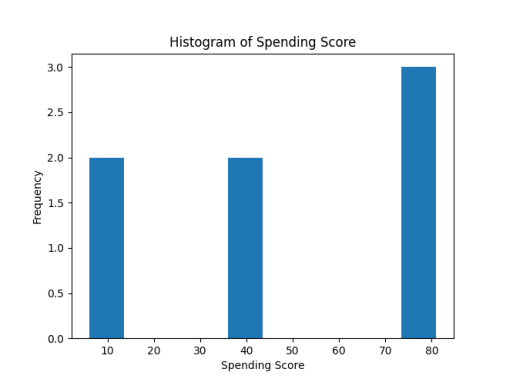

In [32]:
# Plot histogram
sdf.plot_histogram(column = 'SpendingScore')

### Plot correlation heatmap

<string>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


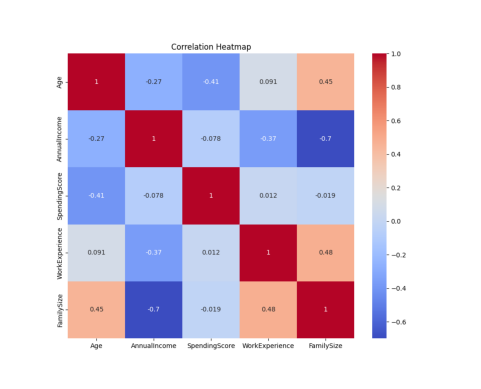

In [33]:
# Generate heatmap of correlations
sdf.plot_correlation_heatmap()

___
## Wrapping it up

These examples showcase the versatility of using LLMs (via `pandasAI`) to simplify our use of `pandas`. The prompts used need to be carefully designed as not all text can be interpreted accurately by the LLMs. To improve the interpretation accuracy, we can leverage more powerful LLMs like OpenAI's GPT4 model.